In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import math
import seaborn as sns

sns.set_theme()

In [2]:
ene = 4.0
ene_str = str(ene).replace('.', '_')

h = 10.0
L = 750
n = 1.05

In [3]:
import ROOT

# Open the .root file
file = ROOT.TFile("../build/test.root")

# Iterate over all items in the file
for key in file.GetListOfKeys():
    obj = key.ReadObj()
    # Check if the object is a tree
    if isinstance(obj, ROOT.TTree):
        tree_name = obj.GetName()
        print(f"Tree: {tree_name}")
        
        # List all branches in the tree
        branches = obj.GetListOfBranches()
        for branch in branches:
            print(f"  Branch: {branch.GetName()}")


/home/electricwiz/miniconda3/envs/DataAnalisis/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/electricwiz/miniconda3/envs/DataAnalisis/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/electricwiz/miniconda3/envs/DataAnalisis/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/electricwiz/miniconda3/envs/DataAnalisis/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/electricwiz/miniconda3/envs/DataAnalisis/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attrib

Welcome to JupyROOT 6.28/04
Tree: PrimaryParticle
  Branch: energyPrimary
  Branch: eventNumber
  Branch: l
  Branch: m
  Branch: n
Tree: Detectors
  Branch: detectorPositionX
  Branch: detectorPositionY
  Branch: eventNumber
  Branch: trackID
  Branch: energy
Tree: CircleCenter
  Branch: centerX
  Branch: centerY
  Branch: eventNumber


In [4]:
# Access the 'Detectors' tree
tree = file.Get("Detectors")

# Define the branches you want to extract
branches = ['detectorPositionX', 'detectorPositionY', 'eventNumber']

# Determine the total number of entries
total_entries = tree.GetEntries()

# Define the chunk size
chunk_size = 1500000000 # Adjust based on your system's RAM

# Initialize a list for the chunk DataFrames
dfs = []

# Process the tree in chunks
for start in range(0, total_entries, chunk_size):
    end = min(start + chunk_size, total_entries)
    data_list = []

    # Loop over the entries in the current chunk
    for i in range(start, end):
        tree.GetEntry(i)
        # Access branch data directly
        data = {branch: getattr(tree, branch) for branch in branches}
        data_list.append(data)

    # Convert the chunk to a DataFrame
    chunk_df = pd.DataFrame(data_list)

    # Convert the 'eventNumber' column to int32
    chunk_df['eventNumber'] = chunk_df['eventNumber'].astype('int32')

    # Add the chunk DataFrame to the list
    dfs.append(chunk_df)

    # Delete the data list to free up memory
    del data_list

    # Force the garbage collector to release unreferenced memory
    gc.collect()

# Concatenate all chunk DataFrames
df = pd.concat(dfs, ignore_index=True)


In [5]:
df

,detectorPositionX,detectorPositionY,eventNumber
0,4.25,4.25,510
1,184.25,-245.75,510
2,-5.75,-395.75,510
3,0.00,0.00,510
4,-5.75,-375.75,510
...,...,...,...
20541383,-125.75,-335.75,348329
20541384,-115.75,-315.75,348329
20541385,-115.75,-315.75,348329
20541386,-115.75,-325.75,348329


In [6]:
# Now, drop the duplicates
df = df.drop_duplicates(subset=['eventNumber', 'detectorPositionX', 'detectorPositionY'])

gc.collect()

0

In [7]:
# Group by 'eventNumber' and filter out groups with less than 3 elements
df = df.groupby('eventNumber').filter(lambda x: len(x) >= 4)# Calculate group sizes
group_sizes = df.groupby('eventNumber').size()

# Filter out groups with less than 3 elements
df = df[df['eventNumber'].isin(group_sizes[group_sizes >= 3].index)]

In [8]:
# Access the 'PrimaryParticle' tree
ls

In [9]:
# Access the 'CircleCenter' tree
tree = file.Get("CircleCenter")

# Define the branches you want to extract
branches = ['centerX', 'centerY', 'eventNumber']

# Determine the total number of entries
total_entries = tree.GetEntries()

# Define the chunk size
chunk_size = 15000000 # Adjust based on your system's RAM

# Initialize an empty DataFrame for the final result
df2 = pd.DataFrame()

# Process the tree in chunks
for start in range(0, total_entries, chunk_size):
    end = min(start + chunk_size, total_entries)
    data_list = []

    # Loop over the entries in the current chunk
    for i in range(start, end):
        tree.GetEntry(i)
        # Access branch data directly
        data = {branch: getattr(tree, branch) for branch in branches}
        data_list.append(data)

    # Convert the chunk to a DataFrame
    chunk_df2 = pd.DataFrame(data_list)

    chunk_df2['centerX'] = chunk_df2['centerX']
    chunk_df2['centerY'] = chunk_df2['centerY']

    # Append the chunk DataFrame to the main DataFrame
    df2 = pd.concat([df2, chunk_df2], ignore_index=True)

    # Delete the chunk DataFrame and the data list to free up memory
    del chunk_df2
    del data_list

    # Force the garbage collector to release unreferenced memory
    gc.collect()

In [10]:
df1 = df1[df1['eventNumber'].isin(df['eventNumber'])]
df = df[df['eventNumber'].isin(df2['eventNumber'])]
gc.collect()

0

In [11]:
# Merge df with df1 on 'eventNumber', keeping only 'energyprimary' from df1
df = df.merge(df1[['eventNumber', 'energyPrimary', 'l', 'm', 'n']], on='eventNumber', how='left')

del df1
gc.collect()

0

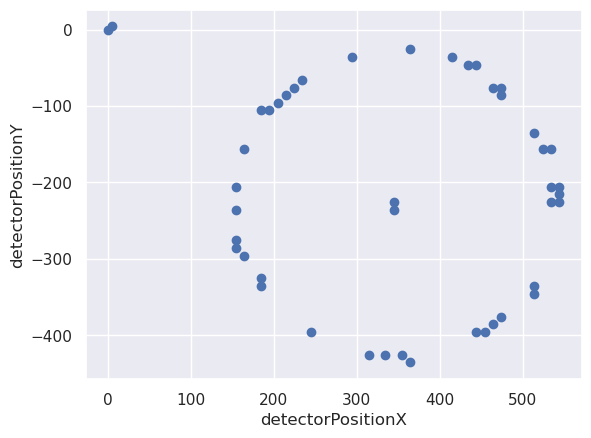

In [12]:
# Filter the DataFrame for a specific eventNumber
event_number = df["eventNumber"].max() 	 	  # replace with your desired event number
df_event = df[df['eventNumber'] == event_number]

# Create a scatter plot of detectorPositionX and detectorPositionY
plt.scatter(df_event['detectorPositionX'], df_event['detectorPositionY'])

# Set the labels for the x and y axes
plt.xlabel('detectorPositionX')
plt.ylabel('detectorPositionY')

# Show the plot
plt.show()

In [13]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma, x0):
    return A * np.where(x < x0, norm.pdf(x, mu, sigma) / norm.pdf(mu, mu, sigma), 0)

def slow_exponential(x, a, b):
    return a * np.exp(-b * x)

def combined_function(x, A=2.007e-1, mu=0, sigma=20, x0=60, a=1.836e-3, b=2.17e-2):
    return np.where(x < x0, gaussian(x, A, mu, sigma, x0), slow_exponential(x, a, b))

In [14]:
from scipy.optimize import minimize
import sys
import multiprocessing as mp

def residuals(x, y, a, b, r, l, m, n):
    h_cone = r * np.sqrt(l**2 + m**2 + n**2) / np.sqrt(l**2 + m**2 + 1e-8)
    tan_theta = np.tan(np.arcsin(np.clip(1/n, -1, 1)))  # Clip to avoid domain errors
    phi = 0.5 * np.arctan2(2*l*m, (n**2 * tan_theta**2 * ((1 + (l/n)**2) - (1 + (m/n)**2))))
    h_ellipse = -l / (n * tan_theta + 1e-8)
    k_ellipse = -m / (n * tan_theta + 1e-8)
    cos_phi, sin_phi = np.cos(phi), np.sin(phi)
    x_rotated = (x - h_ellipse) * cos_phi + (y - k_ellipse) * sin_phi
    y_rotated = (y - k_ellipse) * cos_phi - (x - h_ellipse) * sin_phi
    numerator = a**2 * b**2 * np.maximum(0, 1 - (x_rotated**2 / a**2 + y_rotated**2 / b**2))
    denominator = a**2 * y_rotated**2 + b**2 * x_rotated**2

    return np.sqrt(numerator / np.maximum(denominator, 1e-8))

def negative_log_likelihood(theta, x, y, l, m, n):
    a, b, r = theta
    ri = residuals(x, y, a, b, r, l, m, n)
    
    with np.errstate(invalid='ignore', divide='ignore'):
        probabilities = combined_function(ri)

    valid_probs = probabilities[np.isfinite(probabilities) & (probabilities > 0)]
    if len(valid_probs) == 0:
        return np.inf  # Return a large value if all probabilities are invalid
    
    nll = -np.sum(np.log(valid_probs))
    return nll

def process_event(event):
    event_data = df[df['eventNumber'] == event] 
    l, m, n = event_data[['l', 'm', 'n']].values[0]

    if event in df2['eventNumber'].values:
        real_center = df2[df2['eventNumber'] == event][['centerX', 'centerY']].values[0]
        
        initial_guess_r = np.sqrt(np.mean((event_data['detectorPositionX'] - real_center[0])**2 +
                                          (event_data['detectorPositionY'] - real_center[1])**2))
        initial_guess = [real_center[0], real_center[1], initial_guess_r]

        result = minimize(
            negative_log_likelihood,
            initial_guess,
            args=(event_data['detectorPositionX'].values,
                  event_data['detectorPositionY'].values,
                 l, m, n),
            method='L-BFGS-B',
            bounds=[(-650, 650), (-650, 650), (15, 1840)],
            options={'ftol':1e-2, 'gtol':1e-2, 'maxiter':1000}
        )
        if result.success:
            return {
                'eventNumber': event,
                'centerX': result.x[0],
                'centerY': result.x[1],
                'radius': result.x[2]
            }
        
unique_events = df['eventNumber'].unique()

with mp.Pool(mp.cpu_count()) as pool:
    optimized_params_list = pool.map(process_event, unique_events)

optimized_params_list = [x for x in optimized_params_list if x is not None]
optimized_params_df = pd.DataFrame(optimized_params_list)

df = pd.merge(df, optimized_params_df, on='eventNumber', how='left', suffixes=('', '_new'))

del df2
gc.collect()

/tmp/ipykernel_2359/3802739175.py:14: RuntimeWarning: divide by zero encountered in divide
  numerator = a**2 * b**2 * np.maximum(0, 1 - (x_rotated**2 / a**2 + y_rotated**2 / b**2))
/tmp/ipykernel_2359/3802739175.py:14: RuntimeWarning: invalid value encountered in divide
  numerator = a**2 * b**2 * np.maximum(0, 1 - (x_rotated**2 / a**2 + y_rotated**2 / b**2))
/tmp/ipykernel_2359/3802739175.py:14: RuntimeWarning: divide by zero encountered in divide
  numerator = a**2 * b**2 * np.maximum(0, 1 - (x_rotated**2 / a**2 + y_rotated**2 / b**2))
/tmp/ipykernel_2359/3802739175.py:14: RuntimeWarning: invalid value encountered in divide
  numerator = a**2 * b**2 * np.maximum(0, 1 - (x_rotated**2 / a**2 + y_rotated**2 / b**2))
/tmp/ipykernel_2359/3802739175.py:14: RuntimeWarning: divide by zero encountered in divide
  numerator = a**2 * b**2 * np.maximum(0, 1 - (x_rotated**2 / a**2 + y_rotated**2 / b**2))
/tmp/ipykernel_2359/3802739175.py:14: RuntimeWarning: invalid value encountered in divide
  

0

In [15]:
df = pd.merge(df, optimized_params_df, on='eventNumber', how='left', suffixes=('', '_new'))

df.rename(columns={'centerX_new': 'centerX', 'centerY_new': 'centerY'}, inplace=True)

del optimized_params_df
gc.collect()

0

In [16]:
# Convert columns back to float16
df['eventNumber'] = df['eventNumber'].astype('int32')
df['detectorPositionX'] = df['detectorPositionX']
df['detectorPositionY'] = df['detectorPositionY']

gc.collect()

0

In [17]:
def calculate_beta(cherenkov_angle, refractive_index):
    # Check if refractive index is non-zero to avoid division by zero
    if np.any(refractive_index == 0):
        raise ValueError("Refractive index cannot be zero.")

    # Calculate beta using the Cherenkov angle and refractive index
    beta = 1 / np.cos(cherenkov_angle) / refractive_index

    return beta

def calculate_beta_proton(energy_gev):
    rest_mass_energy_mev = 938.272
    energy_mev = energy_gev * 1000
    gamma = 1 + (energy_mev / rest_mass_energy_mev)
    beta = np.sqrt(1 - 1 / gamma**2)

    return beta

def calculate_radius(ene, n=n, h=h, L=L):
    beta = calculate_beta_proton(ene)
    theta = np.arccos(1/(beta*n))

    return L * np.tan(np.arcsin(n * np.sin(theta))) + (h / 2) * np.tan(theta)


In [18]:
df["radius_gev"] = calculate_radius(df["energyPrimary"])
df["residual"] = np.abs(df["radius_gev"] - df["radius"])

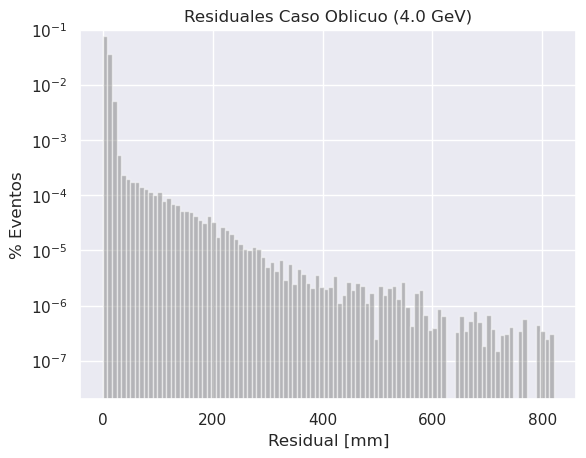

In [19]:
plt.hist(df["residual"], bins=100, density=True, log=True, color='gray', alpha=0.5)
plt.ylim([2e-8, 1e-1])

plt.xlabel('Residual [mm]')
plt.ylabel('% Eventos')

plt.title("Residuales Caso Oblicuo" + f" ({ene} GeV)")

plt.savefig("perpendicular.png")
plt.show()

In [20]:
filtered_df = df[(df['residual'] >= 160) & (df['residual'] <= 240)]
value_counts = filtered_df['residual'].value_counts()
highest_count_bin = value_counts.idxmax()

print(f"The bin with the highest count between 170 and 220 is: {highest_count_bin}")

The bin with the highest count between 170 and 220 is: 178.69833450336185


In [21]:
sorted_value_counts = value_counts.sort_values(ascending=False)
second_highest_count_bin = sorted_value_counts.index[1]

print(f"The bin with the second highest count between 170 and 220 is: {second_highest_count_bin}")

The bin with the second highest count between 170 and 220 is: 166.26104031615066


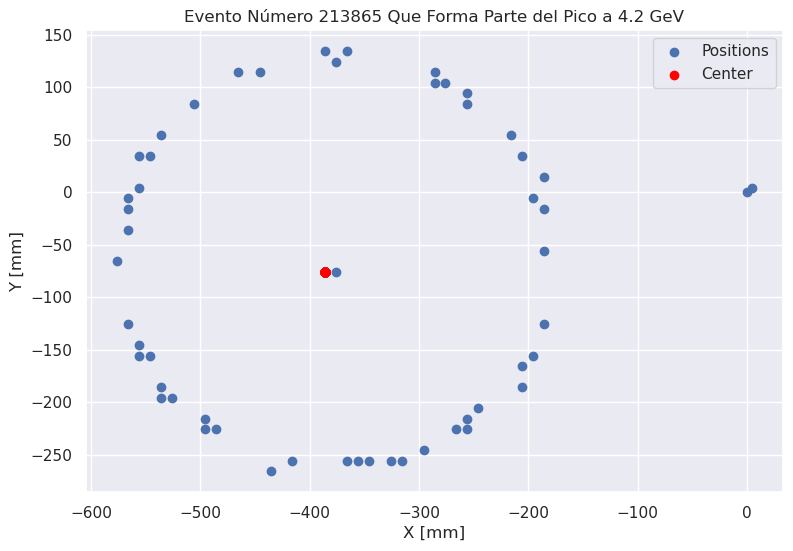

In [22]:
random_event_number = df['eventNumber'].sample(1).values[0]

# Create a plot for the selected event
fig, ax = plt.subplots(figsize=(9, 6))

# Select all rows for the current 'eventNumber'
event = df[df['eventNumber'] == random_event_number]
ax.scatter(event['detectorPositionX'], event['detectorPositionY'], label='Positions')


# Calculate and plot the center position
center_x = event["centerX"]
center_y = event['centerY']
ax.scatter(center_x, center_y, color='red', label='Center')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend()

plt.title(f"Evento Número {random_event_number} Que Forma Parte del Pico a 4.2 GeV")
plt.show()

Optimized parameters: [8.12797441e-02 4.17137370e+00 6.30067889e+00 7.50000000e+01
 3.43870933e-04 1.23627854e-02]


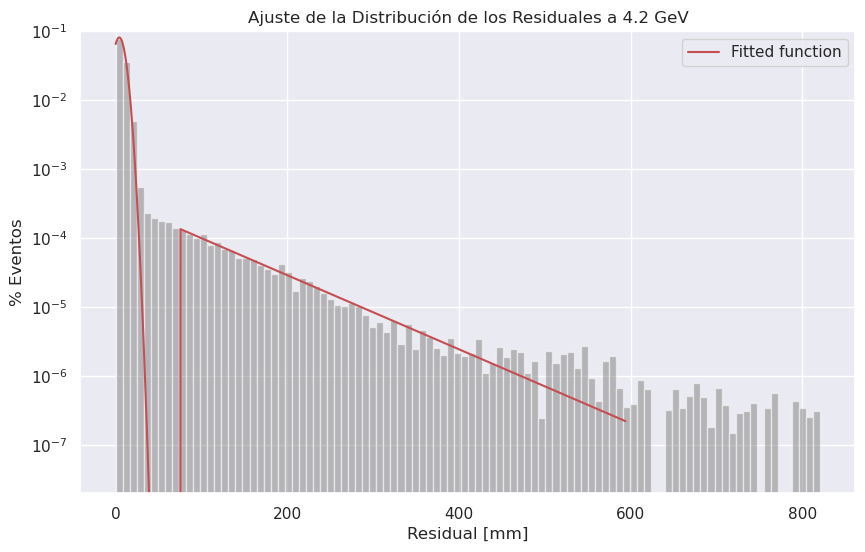

In [23]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian(x, A, mu, sigma, x0):
    return A * np.where(x < x0, norm.pdf(x, mu, sigma) / norm.pdf(mu, mu, sigma), 0)

def slow_exponential(x, a, b):
    return a * np.exp(-b * x)

def combined_function(x, A, mu, sigma, x0, a, b):
    return np.where(x < x0, gaussian(x, A, mu, sigma, x0), slow_exponential(x, a, b))

# Get the histogram data
# Filter the 'residual' column
filtered_residual = df['residual'][df['residual'] <= 600]

# Get the histogram data
hist, bin_edges = np.histogram(filtered_residual, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the function to the histogram data
popt, pcov = curve_fit(combined_function, bin_centers, hist, 
                       p0=[0.2, 0, 6, 75, 0.001, 0.0004],
                       method='dogbox',
                       ftol=1e-5, 
                       gtol=1e-5,
                       max_nfev=100000)

# Print the optimized parameters
print("Optimized parameters:", popt)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df["residual"], bins=100, density=True, log=True, color='gray', alpha=0.5)

# Plot the fitted function
x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.plot(x, combined_function(x, *popt), 'r-', label='Fitted function')

plt.xlabel('Residual [mm]')
plt.ylabel('% Eventos')
plt.title("Ajuste de la Distribución de los Residuales a 4.2 GeV")
plt.ylim([2e-8, 1e-1])
plt.legend()

plt.show()

In [24]:
# Get eventNumbers with variance > 0 and < 100
good_eventNumbers = df.loc[(df['residual'] > 0) & (df['residual'] < 50), 'eventNumber']

# Get eventNumbers with variance > 100
bad_eventNumbers = df.loc[df['residual'] > 100, 'eventNumber']

# Create df_good DataFrame
df_good = df.loc[df['eventNumber'].isin(good_eventNumbers)].copy()

# Create df_bad DataFrame
df_bad = df.loc[df['eventNumber'].isin(bad_eventNumbers)].copy()

# Delete unused variables and original df
del df, good_eventNumbers, bad_eventNumbers
gc.collect()

37519

In [25]:
import matplotlib.pyplot as plt
plt.hist(variance_df["residual"], bins=100, range=(0, 500), log = True, density=True)

plt.title('Histograma del Residual Normalizado por El Número de Fotones Cherenkov')
plt.xlabel('Residual Normalizado')
plt.ylabel('% Eventos')

plt.savefig("normalizado2cm.png")

plt.show()

NameError: name 'variance_df' is not defined

In [ ]:
"""import math

def inc(n, R, h = 76.5):
    return 1.202/(math.sin(math.atan(R/h))*(math.cos(math.atan(R/h))**2)*n*h*(1 + (R/h)**2))"""

'import math\n\ndef inc(n, R, h = 76.5):\n    return 1.202/(math.sin(math.atan(R/h))*(math.cos(math.atan(R/h))**2)*n*h*(1 + (R/h)**2))'

In [ ]:
import tensorflow as tf

# Group the DataFrame by 'eventNumber' and save each group as an element in a list
groups1 = [group for _, group in df_good.groupby('eventNumber')]
groups2 = [group for _, group in df_bad.groupby('eventNumber')]

# Get the labels (the 'eventNumber' column)
labels1 = df_good.groupby('eventNumber')['energyPrimary'].first().values
labels2 = df_bad.groupby('eventNumber')['energyPrimary'].first().values

In [ ]:
def serialize_example(group, label):
    # Convert the 'detectorPositionX', 'detectorPositionY', 'duplicates_count' columns to floats
    detectorPositionX_floats = group['detectorPositionX'].values.astype(float)
    detectorPositionY_floats = group['detectorPositionY'].values.astype(float)
    label_float = float(label)

    feature = {
        'detectorPositionX': tf.train.Feature(float_list=tf.train.FloatList(value=detectorPositionX_floats)),
        'detectorPositionY': tf.train.Feature(float_list=tf.train.FloatList(value=detectorPositionY_floats)),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[label_float])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Write the dataset to a TFRecord file
with tf.io.TFRecordWriter('good3_0.tfrecords') as writer:
    for group, label in zip(groups1, labels1):
        example = serialize_example(group, label)
        writer.write(example)

with tf.io.TFRecordWriter('bad3_0.tfrecords') as writer:
    for group, label in zip(groups2, labels2):
        example = serialize_example(group, label)
        writer.write(example)

In [ ]:
"""df_good.loc[:, "beta_hat"] = calculate_beta(df_good["radius"].apply(calculate_half_angle), 1.05)

df_bad.loc[:, "beta_hat"] = calculate_beta(df_bad["radius"].apply(calculate_half_angle), 1.05)"""

'df_good.loc[:, "beta_hat"] = calculate_beta(df_good["radius"].apply(calculate_half_angle), 1.05)\n\ndf_bad.loc[:, "beta_hat"] = calculate_beta(df_bad["radius"].apply(calculate_half_angle), 1.05)'

In [ ]:
df_good["beta_hat"] = calculate_beta_proton(df_good["radius"])
df_bad|["beta_hat"] = calculate_beta_proton(df_bad["radius"])

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (4033453458.py, line 2)

In [ ]:
from scipy.optimize import curve_fit

def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

for idx, ene in enumerate(enes):
    df_good_grouped = df_good.groupby('eventNumber').first()
    df_bad_grouped = df_bad.groupby('eventNumber').first()

    bin_width = 0.001

    bins_good = np.arange(min(df_good_grouped["beta_hat"]), max(df_good_grouped["beta_hat"]) + bin_width, bin_width)
    counts_good, _ = np.histogram(df_good_grouped["beta_hat"], bins=bins_good)
    bins_bad = np.arange(min(df_bad_grouped["beta_hat"]), max(df_bad_grouped["beta_hat"]) + bin_width, bin_width)
    counts_bad, _ = np.histogram(df_bad_grouped["beta_hat"], bins=bins_bad)
    counts_good = counts_good / np.sum(counts_good)
    counts_bad = counts_bad / np.sum(counts_bad)

    bin_centers_good = (bins_good[:-1] + bins_good[1:]) / 2
    bin_centers_bad = (bins_bad[:-1] + bins_bad[1:]) / 2 

    ax.bar(bin_centers_good, counts_good, width=np.diff(bins_good), color='g', alpha=1, zorder=2)

    initial_guess_good = [max(counts_good), bin_centers_good[np.argmax(counts_good)], np.std(df_good_grouped["beta_hat"])]
    popt_good, _ = curve_fit(gaussian, bin_centers_good, counts_good, p0=initial_guess_good, maxfev=5000)
    x_good = np.linspace(min(bin_centers_good), max(bin_centers_good), 1000)
    ax.plot(x_good, gaussian(x_good, *popt_good), 'r-', zorder=3)
    ax.axvline(popt_good[1], color='r', linestyle='--')
    ax.bar(bin_centers_bad, counts_bad, width=np.diff(bins_bad), color='b', alpha=0.6, zorder=1)

    beta_r = calculate_beta_proton(ene)
    ax.axvline(beta_r, color='gold', linestyle='--')

    ax.set_xlim([0.962, 1.04])
    ax.set_ylim([1e-3, 1.2])

    ax.set_yscale('log')

    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel('% Eventos')

    line_good, = ax.plot(x_good, gaussian(x_good, *popt_good), 'r-', zorder=3) 

    line_beta_r = ax.axvline(beta_r, color='black', linestyle='--')

    lower_bound = beta_r - 0.005*beta_r
    upper_bound = beta_r + 0.005*beta_r

    num_events_in_range = df_good_grouped[(df_good_grouped["beta_hat"] >= lower_bound) & (df_good_grouped["beta_hat"] <= upper_bound)].shape[0]

    total_events = df_good_grouped.shape[0]
    efficiency = num_events_in_range / total_events
    efficiencies.append(efficiency)

    median_bad = df_bad_grouped["beta_hat"].median()
    line_median_bad = ax.axvline(median_bad, color='purple', linestyle='--')

    ax.legend([line_good, line_beta_r, line_median_bad], 
              [f'$<\\beta_{{Buenos}}>$ = {popt_good[1]:.4f}', 
               f'$\\beta_{{Real}}$ = {beta_r:.4f}', 
               f'Mediana $\\beta_{{Malos}}$ = {median_bad:.4f}'], 
              title='Betas Calculadas')

    ax.set_title(f'  {str(ene)} GeV Con Likelihood, Eficiencia = {efficiency*100:.4f} %')

fig.tight_layout()
fig.savefig(f"./figures/pLike9.png")

plt.show()

KeyError: 'beta_hat'

In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np

def draw_circle(ax, centerX, centerY, radius, color):
    circle = plt.Circle((centerX, centerY), radius, fill=False, color=color)
    ax.add_artist(circle)
    ax.plot(centerX, centerY, marker='o', color=color)  # plot the center
    
# Assuming good_events and bad_events are DataFrames grouped by 'eventNumber'
good_events = df_good.groupby('eventNumber')
bad_events = df_bad.groupby('eventNumber')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot for df_good
for i, (eventNumber, event) in enumerate(good_events):
    if i > 1:  # Limit the number of plots to the size of the axs array
        break
    axs[0, i].scatter(event.detectorPositionX, event.detectorPositionY, color='blue')
    draw_circle(axs[0, i], event.centerX.mean(), event.centerY.mean(), event.radius.mean(), 'magenta')

# Plot for df_bad
for i, (eventNumber, event) in enumerate(bad_events):
    if i > 1:  # Limit the number of plots to the size of the axs array
        break
    axs[1, i].scatter(event.detectorPositionX, event.detectorPositionY, color='yellow')
    draw_circle(axs[1, i], event.centerX.mean(), event.centerY.mean(), event.radius.mean(), 'cyan')

plt.show()"""

In [ ]:
betas = [calculate_beta_proton(ene) for ene in enes]

plt.title("Eficiencia en Función de la Velocidad")

plt.xlabel(r'$\beta$')
plt.ylabel("% Eficiencia")

plt.plot(betas, [efe*100 for efe in efficiencies])